In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tire
import car
from scipy.optimize import newton
con = 180/np.pi

In [2]:
params = {
    'W_uf' : 111,    #Front unsprung weight (N)
    'W_ur' : 111,    #Rear unsprung weight  (N)
    'W_s'  : 2446,   #Sprung weight         (N)
    # CG locations
    'z_wf' : 0.21,   #Front unsprung height (m)
    'z_wr' : 0.21,   #Rear unsprung height  (m)
    'h_s'  : 0.23,   #Sprung height         (m)
    'a_s'  : 0.76,   #Sprung distance from front axle (m)
    # Car geometry
    'l'    : 1.524,  #Wheelbase   (m)
    't_f'  : 1.22,   #Front track (m)
    't_r'  : 1.22,   #Rear track  (m)
    # Roll center heights
    'z_rf' : 0.038,  #Front roll center height (m)
    'z_rr' : 0.076,  #Rear roll center height  (m)
    # Roll rates
    'K_f'  : 16.5e3, #Front roll rate (N-m/rad)
    'K_r'  : 32.0e3, #Rear roll rate  (N-m/rad)
    # Steering
    'ack'  : 0.0,    #Steering Ackerman (%)
    'toe_f': 0.5,   #Front toe (deg)
    'toe_r': 1.0,    #Rear toe  (deg)
    'tire' : tire.Hoosier10X7()
}
C = car.Car(params)

Roll axis inclination: 1.43 deg
Unsprung CG height from roll axis: 0.17 m
Roll sensitivity: -0.50 deg/g
Front lateral weight transfer: 174.81 N/g
Rear lateral weight transfer:  324.43 N/g
Longitudinal weight transfer:       399.74 N/g
Front static wheel load:            -668.60 N
Rear static wheel load:             -665.40 N
Total weight:     -2668.00 N


C:\Users\Robert\Dropbox\FSAE\Calculations\SteadyState\tire.py:32: RuntimeWarning: invalid value encountered in sqrt
  multi = np.sqrt(1-(Fx/(Fz*mux))**2) * 0.65
C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


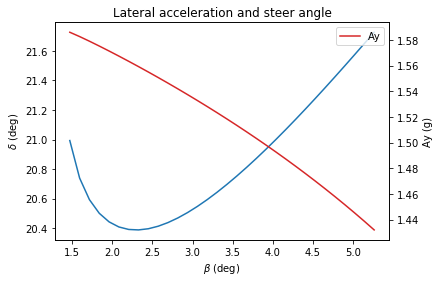

In [3]:
N = 50
r = 4
beta = np.linspace(0, 6, N)
beta *= 1/con
delta = np.zeros(N, dtype='double')
Ay = np.zeros(N, dtype='double')
Fx = np.zeros(N, dtype='double')
load = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
KA = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
SA = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
F = {}
FE = {}
for i in range(N):
    delta[i] = C.get_delta(r, beta[i])
    Ay[i], Fx[i], load[i], KA[i], SA[i], F[i], FE[i] = C.Ay_Fx_from_angle(r, beta[i], delta[i], extra=True)

sel = Ay > 0
plt.plot(beta[sel]*con, delta[sel]*con, 'tab:blue')
plt.title('Lateral acceleration and steer angle')
plt.xlabel(r'$\beta$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.twinx()
plt.plot(beta[sel]*con, Ay[sel], 'tab:red')
plt.ylabel(r'Ay (g)')
plt.legend([r'Ay'])
plt.show()

In [4]:
# First step, analyze the existing car design to see where improvement can be made
sel = np.invert(np.isnan(Ay))
betaM = beta[sel][0]
deltaM = delta[sel][0]
AyM, FxM, loadM, KAM, SAM, FM, FEM = C.Ay_Fx_from_angle(r, betaM, deltaM, extra=True)
SAP = C.calc_peak_slip_angles(loadM)
FCM = C.get_chassis_tire_forces(FM, KAM, betaM)
MzM = C.calc_yaw_moment(FCM)
C.print_force_info(AyM, betaM, deltaM, MzM, KAM, SAM, SAP, loadM, FM, FEM, FCM)

Values at the maximum
---------------------------------------------------------------------
Ay:              1.59 g
Beta:            1.47 deg
Delta:           20.99 deg
Mz:              -0.00 N-m

Wheel parameters             FR          FL          RR          RL
---------------------------------------------------------------------
Kin angle (deg):         -19.02,     -20.02,       2.47,       0.47
Slip angle (deg):         -6.21,     -10.89,     -10.04,      -9.17
Peak angle (deg):          6.02,       9.66,       4.73,      11.39

Wheel loads (N):        -407.70,    -962.02,    -134.75,   -1163.53
Tire lon forces (N):       0.00,       0.00,     397.06,     397.06
Tire lat forces (N):     792.76,    1633.95,     230.28,    1737.26
Eff lon forces (N):     -258.41,    -559.48,     406.61,     411.28
Eff lat forces (N):      749.46,    1535.17,     212.96,    1733.95
Cha lon forces (N):     -277.54,    -598.67,     401.02,     366.68
Cha lat forces (N):      742.58,    1520.32,     223

Roll axis inclination: 1.43 deg
Unsprung CG height from roll axis: 0.17 m
Roll sensitivity: -0.50 deg/g
Front lateral weight transfer: 174.81 N/g
Rear lateral weight transfer:  324.43 N/g
Longitudinal weight transfer:       399.74 N/g
Front static wheel load:            -668.60 N
Rear static wheel load:             -665.40 N
Total weight:     -2668.00 N


C:\Users\Robert\Dropbox\FSAE\Calculations\SteadyState\tire.py:32: RuntimeWarning: invalid value encountered in sqrt
  multi = np.sqrt(1-(Fx/(Fz*mux))**2) * 0.65
C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater


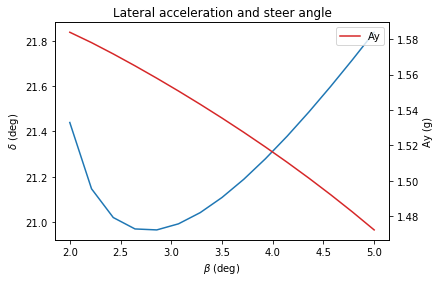

In [6]:
params = {
    'W_uf' : 111,    #Front unsprung weight (N)
    'W_ur' : 111,    #Rear unsprung weight  (N)
    'W_s'  : 2446,   #Sprung weight         (N)
    # CG locations
    'z_wf' : 0.21,   #Front unsprung height (m)
    'z_wr' : 0.21,   #Rear unsprung height  (m)
    'h_s'  : 0.23,   #Sprung height         (m)
    'a_s'  : 0.76,   #Sprung distance from front axle (m)
    # Car geometry
    'l'    : 1.524,  #Wheelbase   (m)
    't_f'  : 1.22,   #Front track (m)
    't_r'  : 1.22,   #Rear track  (m)
    # Roll center heights
    'z_rf' : 0.038,  #Front roll center height (m)
    'z_rr' : 0.076,  #Rear roll center height  (m)
    # Roll rates
    'K_f'  : 16.5e3, #Front roll rate (N-m/rad)
    'K_r'  : 32e3, #Rear roll rate  (N-m/rad)
    # Steering
    'ack'  : -0.0,    #Steering Ackerman (%)
    'toe_f': 0.5,   #Front toe (deg)
    'toe_r': 1.5,    #Rear toe  (deg)
    'tire' : tire.Hoosier10X7()
}
C = car.Car(params)
N = 50
r = 4
beta = np.linspace(-2.5, 8, N)
beta *= 1/con
delta = np.zeros(N, dtype='double')
Ay = np.zeros(N, dtype='double')
Fx = np.zeros(N, dtype='double')
load = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
KA = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
SA = np.zeros(N, dtype=[('fr', 'double'), ('fl', 'double'), ('rr', 'double'), ('rl', 'double')])
F = {}
FE = {}
for i in range(N):
    delta[i] = C.get_delta(r, beta[i])
    Ay[i], Fx[i], load[i], KA[i], SA[i], F[i], FE[i] = C.Ay_Fx_from_angle(r, beta[i], delta[i], extra=True)

sel = Ay > 0
plt.plot(beta[sel]*con, delta[sel]*con, 'tab:blue')
plt.title('Lateral acceleration and steer angle')
plt.xlabel(r'$\beta$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.twinx()
plt.plot(beta[sel]*con, Ay[sel], 'tab:red')
plt.ylabel(r'Ay (g)')
plt.legend([r'Ay'])
plt.show()